In [1]:
from semi_auto_ml import AutoCreate,AutoSelect,DataCheck,ModelSelect

2020-12-29 16:30:17,946 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


In [2]:
import featuretools as ft
import pandas as pd
import numpy as np
import sklearn as sk

#### 生成示例数据

In [3]:
breast_df,y = sk.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

In [4]:
# 增加 null/sing/corr_y/id 列使用datacheck
breast_df['unique_col'] = 'drop_val'
null_col = int((breast_df.shape[0]-9)/4)*[np.nan,5,np.nan,np.nan] + list(range(9))
breast_df['null_col'] =null_col
breast_df['person_id'] =breast_df.index

## DataCheck
#### 使用DataCheck的函数，找出数据存在的问题清理数据

In [5]:
dc = DataCheck()

In [6]:
# 检查其中的空值列与唯一值列
null_cols = dc.check_highly_null(breast_df,threshold=0.70)
single_cols = dc.check_single_value(breast_df)
corr_cols = dc.check_highly_corre(breast_df,threshold=0.9)
unless_cols = dc.check_unless_features(breast_df)
# corry_cols = dc.check_target_features(breast_df,'y',threshold = 0.9)

In [7]:
null_cols,single_cols,corr_cols,unless_cols

(['null_col'],
 ['unique_col'],
 ['worst texture',
  'mean perimeter',
  'perimeter error',
  'worst concave points',
  'worst radius',
  'mean concave points',
  'mean area',
  'area error',
  'worst perimeter',
  'worst area'],
 ['person_id'])

In [8]:
#根据需要去除无效列,可以根据需要去除corr_cols
from itertools import chain
remove_cols = list(set(chain(null_cols,single_cols,unless_cols)))

In [9]:
train_df = breast_df.drop(columns=remove_cols)

## AutoCreate
#### 使用AutoCreate生成特征

In [10]:
auto_c = AutoCreate()

In [11]:
# 具体使用参考 feature_create_test
auto_c.create_entity('cancer',train_df,index = 'temp_id',make_index = True)

In [12]:
train_matrix,features_def = auto_c.make_features(target_entity='cancer')

## AutoSelect
#### 使用AutoSelect筛选特征

In [13]:
unless_cols2 = dc.check_unless_features(train_df)
train_df = train_df.drop(columns=unless_cols2)

In [14]:
auto_s = AutoSelect(train_df,y)

In [15]:
sk_fm = auto_s.sk_feature_importances(0.99)

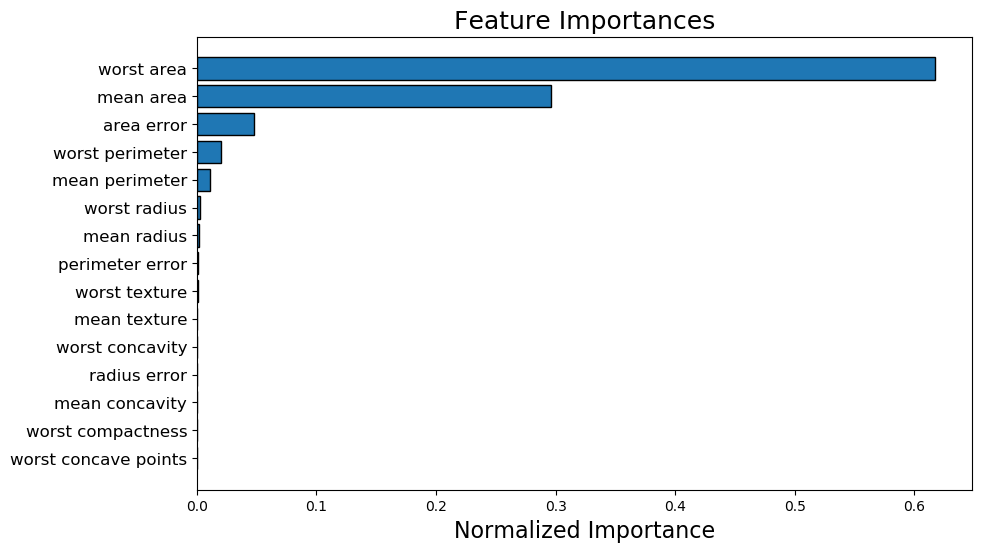

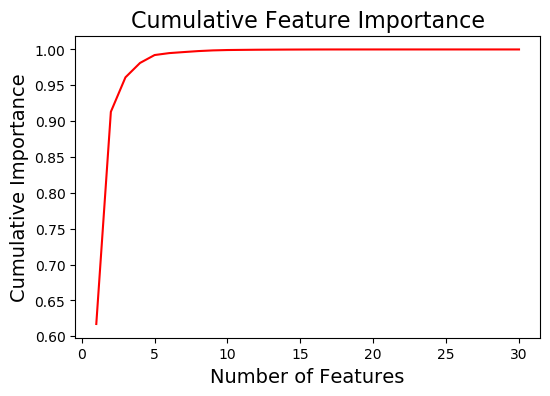

In [16]:
auto_s.plot_feature_importances(sk_fm)

In [17]:
# 得到特征重要程度在0.99之外的特征并移除,保留包含worst的列，也可以传入list
train_df2,features_def = auto_s.remove(keep_cols='worst')

## ModelSelect
#### 选择合适的模型

In [18]:
ms = ModelSelect('binary',max_batches=2)

In [19]:
ranking = ms.search(train_df2,y)

`X` passed was not a DataTable. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
`y` passed was not a DataColumn. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for Log Loss Binary. 
Lower score is better.

Searching up to 2 batches for a total of 14 pipelines. 
Allowed model families: lightgbm, xgboost, extra_trees, random_forest, linear_model, decision_tree, catboost

Batch 1: (1/14) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Log Loss Binary: 12.869
Batch 1: (2/14) Decision Tree Classifier w/ Imputer      Elapsed:00:00
	Starting cross validation
	Finishe

In [20]:
ranking

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,12,Logistic Regression Classifier w/ Imputer + St...,0.071049,0.050600,99.447892,True,{'Imputer': {'categorical_impute_strategy': 'm...
6,6,XGBoost Classifier w/ Imputer,0.114922,0.079051,99.106965,True,{'Imputer': {'categorical_impute_strategy': 'm...
7,7,Random Forest Classifier w/ Imputer,0.116974,0.100089,99.091024,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,2,LightGBM Classifier w/ Imputer,0.121168,0.156976,99.058431,True,{'Imputer': {'categorical_impute_strategy': 'm...
9,3,Extra Trees Classifier w/ Imputer,0.142345,0.141356,98.893872,False,{'Imputer': {'categorical_impute_strategy': 'm...
10,4,Elastic Net Classifier w/ Imputer + Standard S...,0.512550,0.514945,96.017093,False,{'Imputer': {'categorical_impute_strategy': 'm...
11,5,CatBoost Classifier w/ Imputer,0.545796,0.538915,95.758745,False,{'Imputer': {'categorical_impute_strategy': 'm...
12,1,Decision Tree Classifier w/ Imputer,2.077218,1.648244,83.858425,False,{'Imputer': {'categorical_impute_strategy': 'm...
13,0,Mode Baseline Binary Classification Pipeline,12.868741,12.906894,0.000000,False,{'Baseline Classifier': {'strategy': 'mode'}}


In [21]:
# 得到效果最好的模型
ms.auto_ml.best_pipeline

GeneratedPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'median', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Logistic Regression Classifier':{'penalty': 'l2', 'C': 8.279852533149494, 'n_jobs': -1, 'multi_class': 'auto', 'solver': 'lbfgs'},})

In [22]:
#获取某个模型的详细结果
ms.auto_ml.describe_pipeline(6)

*********************************
* XGBoost Classifier w/ Imputer *
*********************************

Problem Type: binary
Model Family: XGBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. XGBoost Classifier
	 * eta : 0.1
	 * max_depth : 6
	 * min_child_weight : 1
	 * n_estimators : 100

Training
Training for binary problems.
Total training time (including CV): 0.4 seconds

Cross Validation
----------------
             Log Loss Binary   AUC    F1  Precision # Training # Testing
0                      0.079 0.997 0.975      0.983    379.000   190.000
1                      0.133 0.990 0.954      0.950    379.000   190.000
2                      0.133 0.991 0.967      0.959    380.000   189.000
mean                   0.115 0.993 0.965      0.964          -         -
std                    0.031 0.003 0.010      0.017          -         -
coef of var      

In [23]:
#获取具体某个模型的feature_importance
xgb_fm = ms.feature_importance(ms.auto_ml.get_pipeline(6),train_df2,y,"F1")

[16:30:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


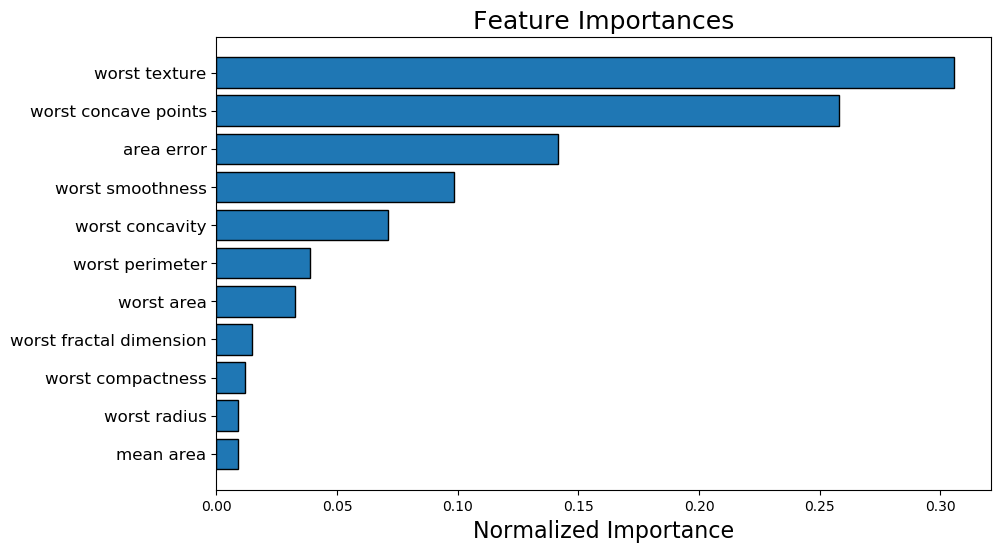

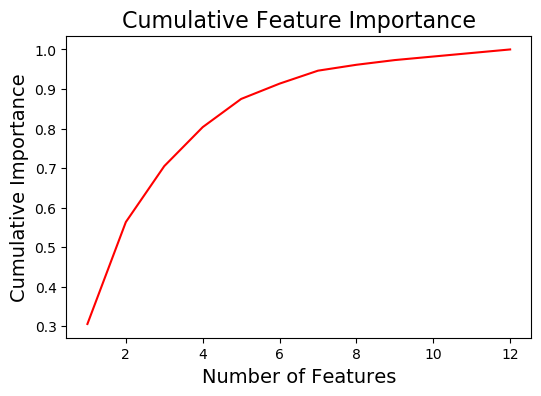

In [24]:
auto_s.plot_feature_importances(xgb_fm)

## MOdel Understanding
#### 直接使用evalml中的方法即可

In [25]:
pipeline=ms.auto_ml.best_pipeline.fit(train_df2,y)

In [27]:
from evalml.model_understanding.graphs import graph_binary_objective_vs_threshold
graph_binary_objective_vs_threshold(pipeline, train_df2,y, 'f1', steps=100)

In [29]:
from evalml.model_understanding.graphs import graph_roc_curve
y_pred_proba = pipeline.predict_proba(train_df2)[1]
graph_roc_curve(y, y_pred_proba)

In [ ]:
# graph_precision_recall_curve/graph_roc_curve/graph_confusion_matrix/graph_permutation_importance/graph_partial_dependence/graph_prediction_vs_actual 等